<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Seasonal-arima-forecasting lab

---


### Lab Guide

- [Load the European retail data](#load-the-european-retail-data)
- [Decompose the timeseries and plot](#decompose-the-timeseries-and-plot)
- [Perform differencing and seasonal differencing of the time series.](#take-a-second-order-difference-of-the-retail-timeseries)
- [Dickey-Fuller test of stationarity](#dickey-fuller-test-of-stationarity)
- [Seasonal ARIMA model (SARIMAX)](#seasonal-arima-with-additional-predictors-sarimax)
- [Forecast using the SARIMAX model](#forecast-using-the-sarimax-model)

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<a id="statsmodels-timeseries-tools"></a>
## Statsmodels timeseries tools
---

Statsmodels, has a wide variety of reliable timeseries analysis tools. We will start off by loading the autocorrelation and partial autocorrelation functions, as well as a function to decompose timeseries.

In [2]:
# this will filter out a lot of future warnings from statsmodels
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load the European retail data
<a id="load-the-european-retail-data"></a>

Create an index representing each quartal.

In [3]:
df = pd.read_csv(
    '../../../../resource-datasets/european_retail_trade/euretail.csv')
df = df.set_index(['Year'])
df.head()

,Qtr1,Qtr2,Qtr3,Qtr4
Year,,,,
1996,89.13,89.52,89.88,90.12
1997,89.19,89.78,90.03,90.38
1998,90.27,90.77,91.85,92.51
1999,92.21,92.52,93.62,94.15
2000,94.69,95.34,96.04,96.30


In [4]:
df_stacked = df.stack()
df_stacked.head()

Year         
1996     Qtr1    89.13
         Qtr2    89.52
         Qtr3    89.88
         Qtr4    90.12
1997     Qtr1    89.19
dtype: float64

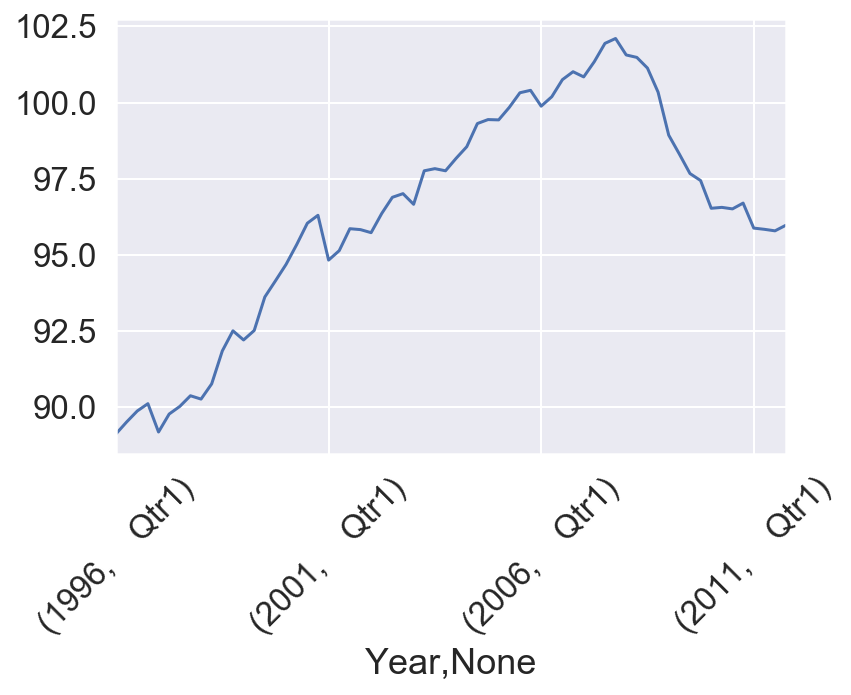

In [5]:
df_stacked.plot()
plt.xticks(rotation=45)
plt.show()

## Decompose the timeseries and plot
<a id="decompose-the-timeseries-and-plot"></a>

Which frequency would you choose for the seasonality?

In [6]:
df_stacked.index = pd.DatetimeIndex(
    start='1996-01-01', periods=len(df_stacked), freq='Q')
df_stacked = pd.DataFrame({'data': df_stacked})
df_stacked.head()

,data
1996-03-31,89.13
1996-06-30,89.52
1996-09-30,89.88
1996-12-31,90.12
1997-03-31,89.19


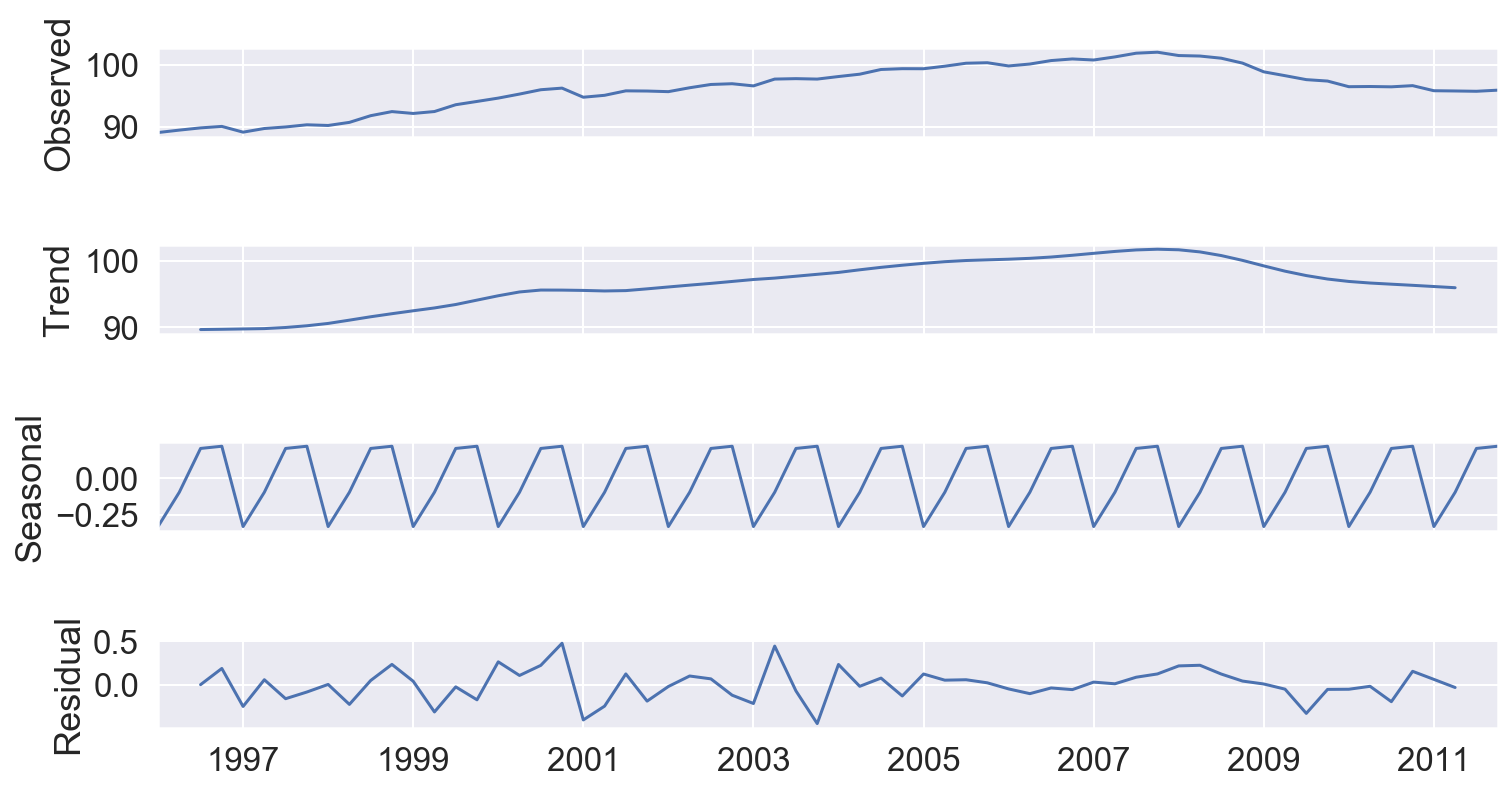

In [7]:
decomposition = seasonal_decompose(df_stacked, freq=4)
fig = decomposition.plot()
fig.set_size_inches(12, 6)
plt.show()

## Perform differencing and seasonal differencing of the time series.
<a id="take-a-second-order-difference-of-the-retail-timeseries"></a>

Plot the ACF and PACF for various combinations of differencing steps.

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [9]:
df_stacked['seasonal_difference'] = df_stacked.data-df_stacked.data.shift(4)

In [10]:
(df_stacked.data-df_stacked.data.shift(4)).head(10)

1996-03-31     NaN
1996-06-30     NaN
1996-09-30     NaN
1996-12-31     NaN
1997-03-31    0.06
1997-06-30    0.26
1997-09-30    0.15
1997-12-31    0.26
1998-03-31    1.08
1998-06-30    0.99
Freq: Q-DEC, Name: data, dtype: float64

In [11]:
(df_stacked.data.diff(4)).head(10)

1996-03-31     NaN
1996-06-30     NaN
1996-09-30     NaN
1996-12-31     NaN
1997-03-31    0.06
1997-06-30    0.26
1997-09-30    0.15
1997-12-31    0.26
1998-03-31    1.08
1998-06-30    0.99
Freq: Q-DEC, Name: data, dtype: float64

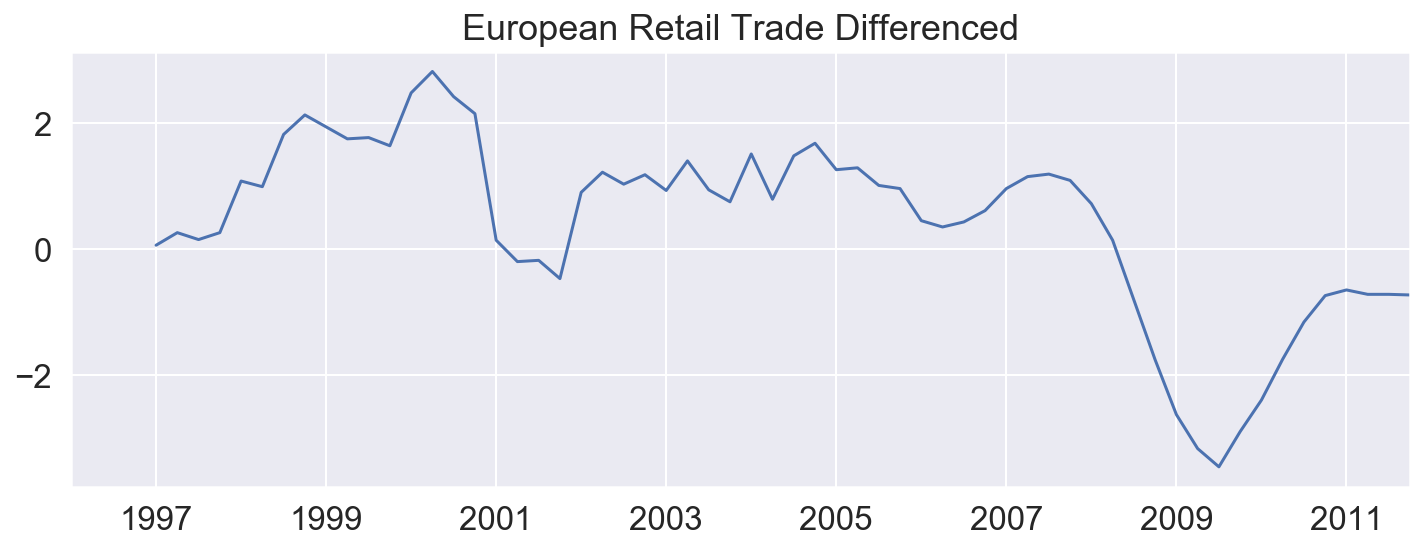

In [12]:
df_stacked.seasonal_difference.plot(
    figsize=(12, 4), title='European Retail Trade Differenced')
plt.show()

In [13]:
def autocorr_plots(y, lags=20, alpha=0.05):
    """
    Plot autocorrelations and partial autocorrelations
    Arguments:
    y: Time series
    lags: Number of lags to plot
    alpha: Confidence level for random noise
    """

    se = stats.norm().ppf(1-alpha/2)/np.sqrt(len(y))

    fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)

    plot_acf(y, lags=lags, alpha=alpha, ax=ax[0])
    ax[0].hlines(np.array([-1, 1])*se, 1, lags, linestyles='--', lw=1)

    plot_pacf(y, lags=lags, alpha=alpha, ax=ax[1], method='ywmle')
    ax[1].hlines(np.array([-1, 1])*se, 1, lags, linestyles='--', lw=1)

    return fig, ax

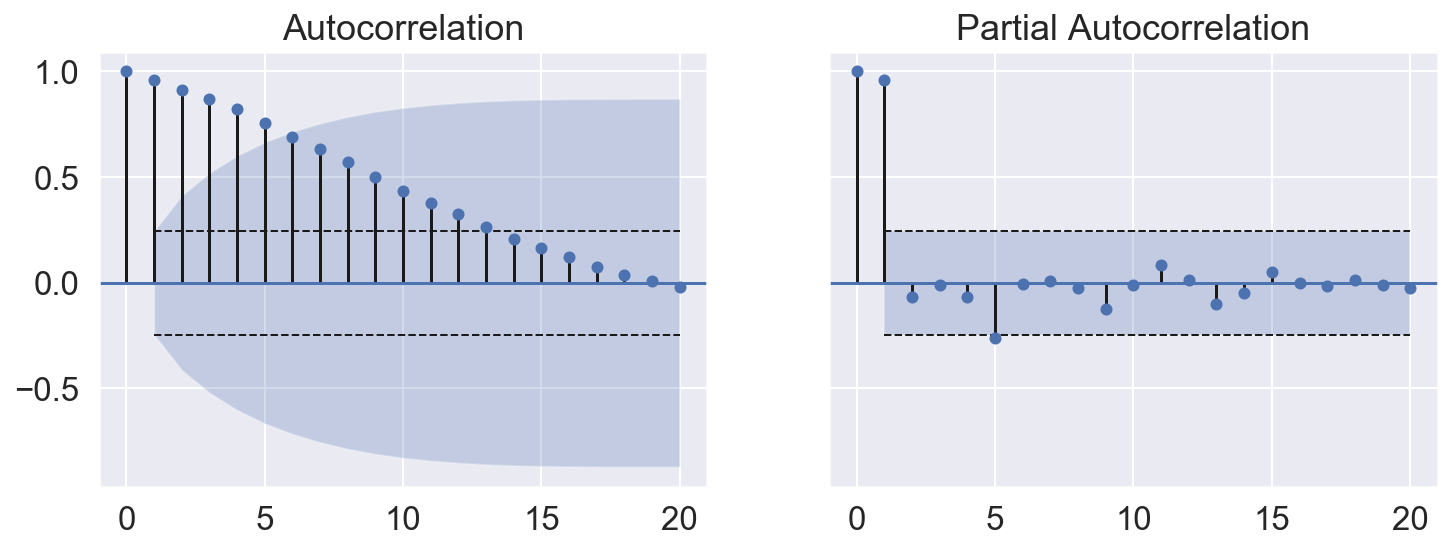

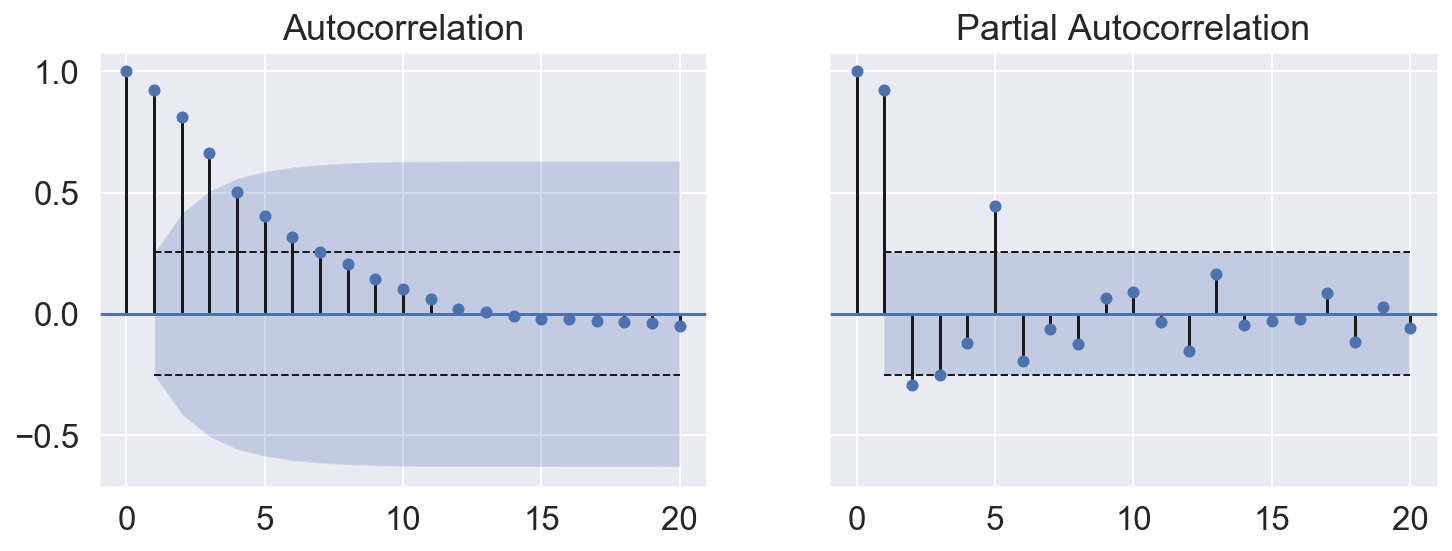

In [14]:
fig, ax = autocorr_plots(df_stacked.data)
fig, ax = autocorr_plots(df_stacked.seasonal_difference.dropna())

## Take a second-order difference of the retail timeseries
<a id="take-a-second-order-difference-of-the-retail-timeseries"></a>

Plot the ACF and PACF again with the second-order differenced series.

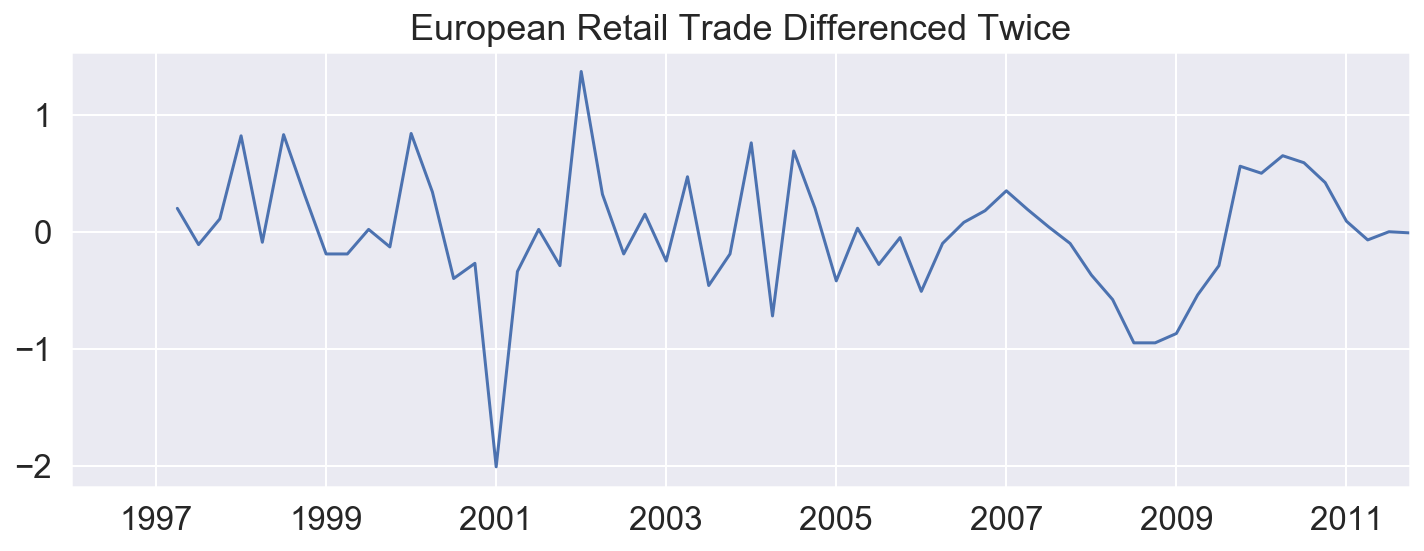

In [15]:
df_stacked['seasonal_difference_diff'] = df_stacked.seasonal_difference.diff()
df_stacked.seasonal_difference_diff.plot(
    figsize=(12, 4), title='European Retail Trade Differenced Twice')
plt.show()

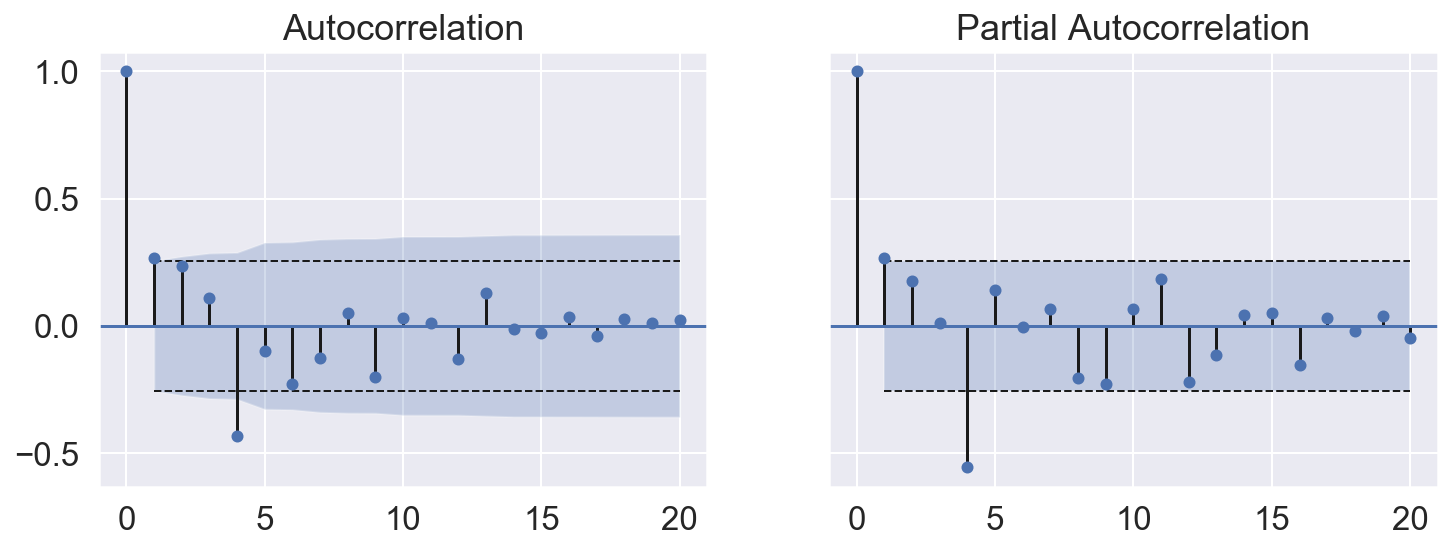

In [16]:
fig, ax = autocorr_plots(df_stacked.seasonal_difference_diff.dropna())

## Dickey-Fuller test of stationarity
<a id="dickey-fuller-test-of-stationarity"></a>

[Perform an (augmented) Dickey-Fuller test of stationarity](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) to evaluate whether or not the timeseries (or the differenced versions you created) are stationary.

In [17]:
from statsmodels.tsa.stattools import adfuller


def get_DF_test(nparray):

    # Perform Dickey-Fuller test:

    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(nparray, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=[
                         'Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in list(dftest[4].items()):
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [18]:
df_stacked.columns

Index(['data', 'seasonal_difference', 'seasonal_difference_diff'], dtype='object')

In [19]:
for col in df_stacked.columns:
    print(col)
    get_DF_test(df_stacked[col].dropna())
    print()

data
Results of Dickey-Fuller Test:
Test Statistic                 -2.300304
p-value                         0.171870
#Lags Used                      8.000000
Number of Observations Used    55.000000
Critical Value (1%)            -3.555273
Critical Value (5%)            -2.915731
Critical Value (10%)           -2.595670
dtype: float64

seasonal_difference
Results of Dickey-Fuller Test:
Test Statistic                 -1.451746
p-value                         0.557233
#Lags Used                      5.000000
Number of Observations Used    54.000000
Critical Value (1%)            -3.557709
Critical Value (5%)            -2.916770
Critical Value (10%)           -2.596222
dtype: float64

seasonal_difference_diff
Results of Dickey-Fuller Test:
Test Statistic                 -3.559370
p-value                         0.006587
#Lags Used                     11.000000
Number of Observations Used    47.000000
Critical Value (1%)            -3.577848
Critical Value (5%)            -2.925338
Criti

## Seasonal ARIMA (SARIMAX)
<a id="seasonal-arima-with-additional-predictors-sarimax"></a>

In [20]:
data = df_stacked.data
model = sm.tsa.statespace.SARIMAX(data,
                                  order=(0, 1, 1),
                                  seasonal_order=(0, 1, 1, 4))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                              data   No. Observations:                   64
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 4)   Log Likelihood                 -34.680
Date:                           Sat, 17 Aug 2019   AIC                             75.360
Time:                                   15:06:49   BIC                             81.593
Sample:                               03-31-1996   HQIC                            77.793
                                    - 12-31-2011                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2901      0.155      1.868      0.062      -0.014       0.594
ma.S.L4       -0.6909      0.132     -5.240      0.000      -0.949      -0.432
sigma2         0.1812      0.034      5.307      0.000       0.114       0.248
===================================================================================
Ljung-Box (Q):                       33.87   Jarque-Bera (JB):                 1.89
Prob(Q):                              0.74   Prob(JB):                         0.39
Heteroskedasticity (H):               0.76   Skew:                            -0.22
Prob(H) (two-sided):                  0.55   Kurtosis:                         3.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Plot the residuals of the SARIMAX model.

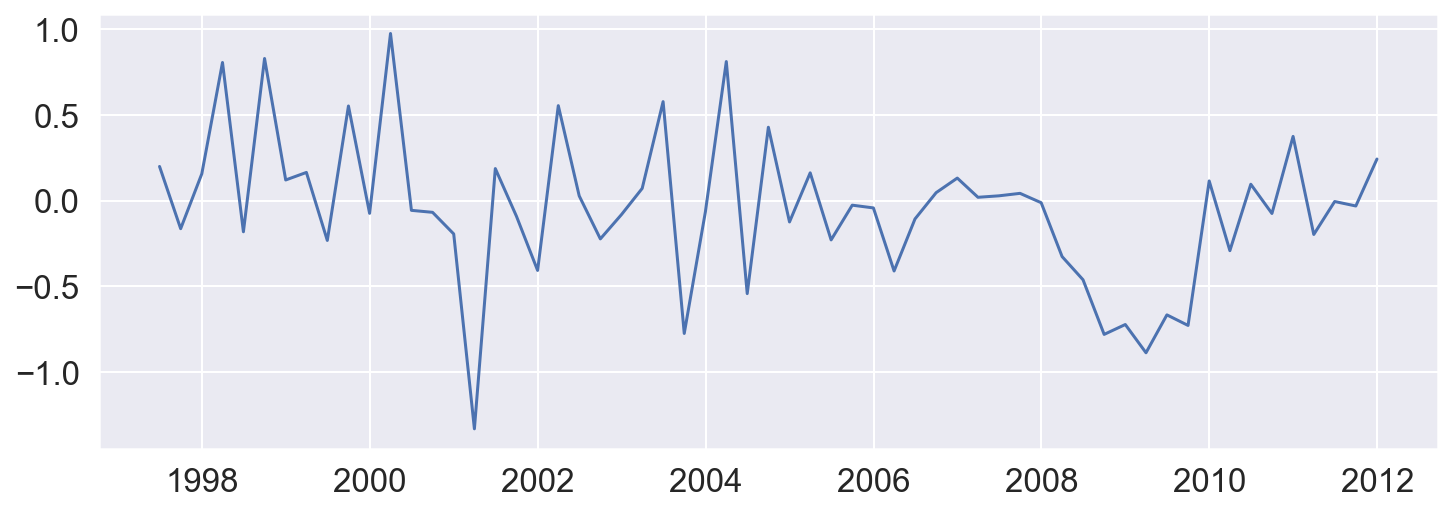

In [21]:
# Don't plot the first five residuals here which are very different in magnitude
residuals = results.resid[5:]
plt.figure(figsize=(12, 4))
plt.plot(residuals)
plt.show()

## Plot the ACF and PACF of the residuals.

What should we be expecting from the ACF and PACF of our residuals if the model is good?

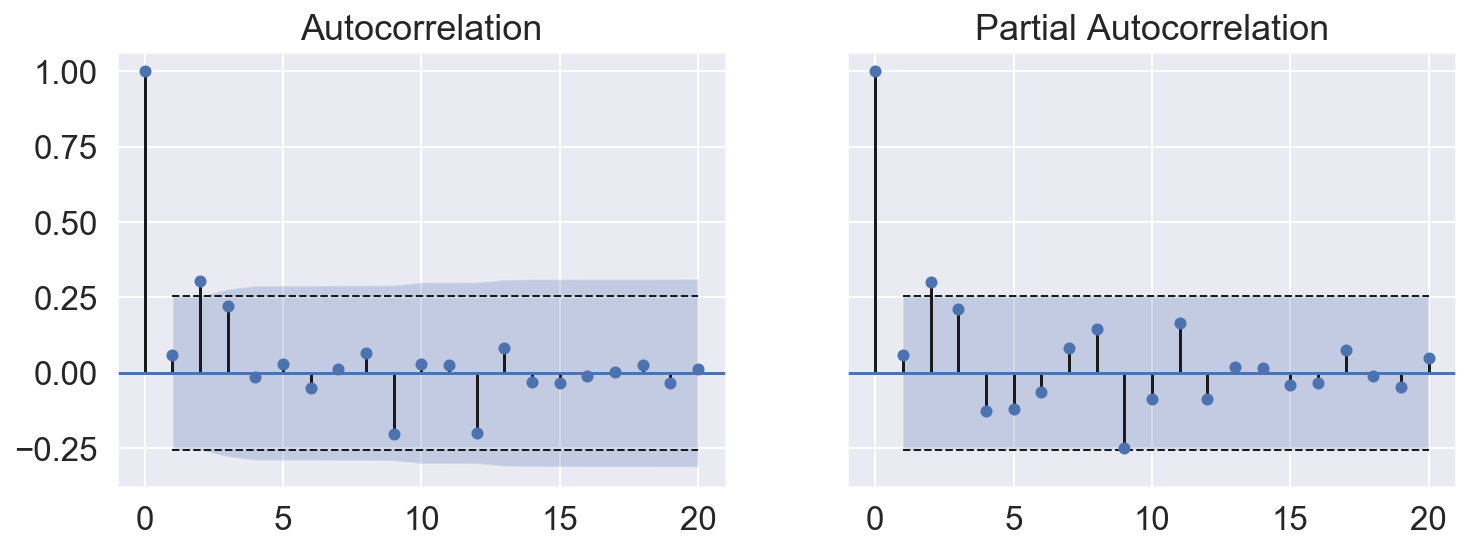

In [22]:
fig, ax = autocorr_plots(residuals)

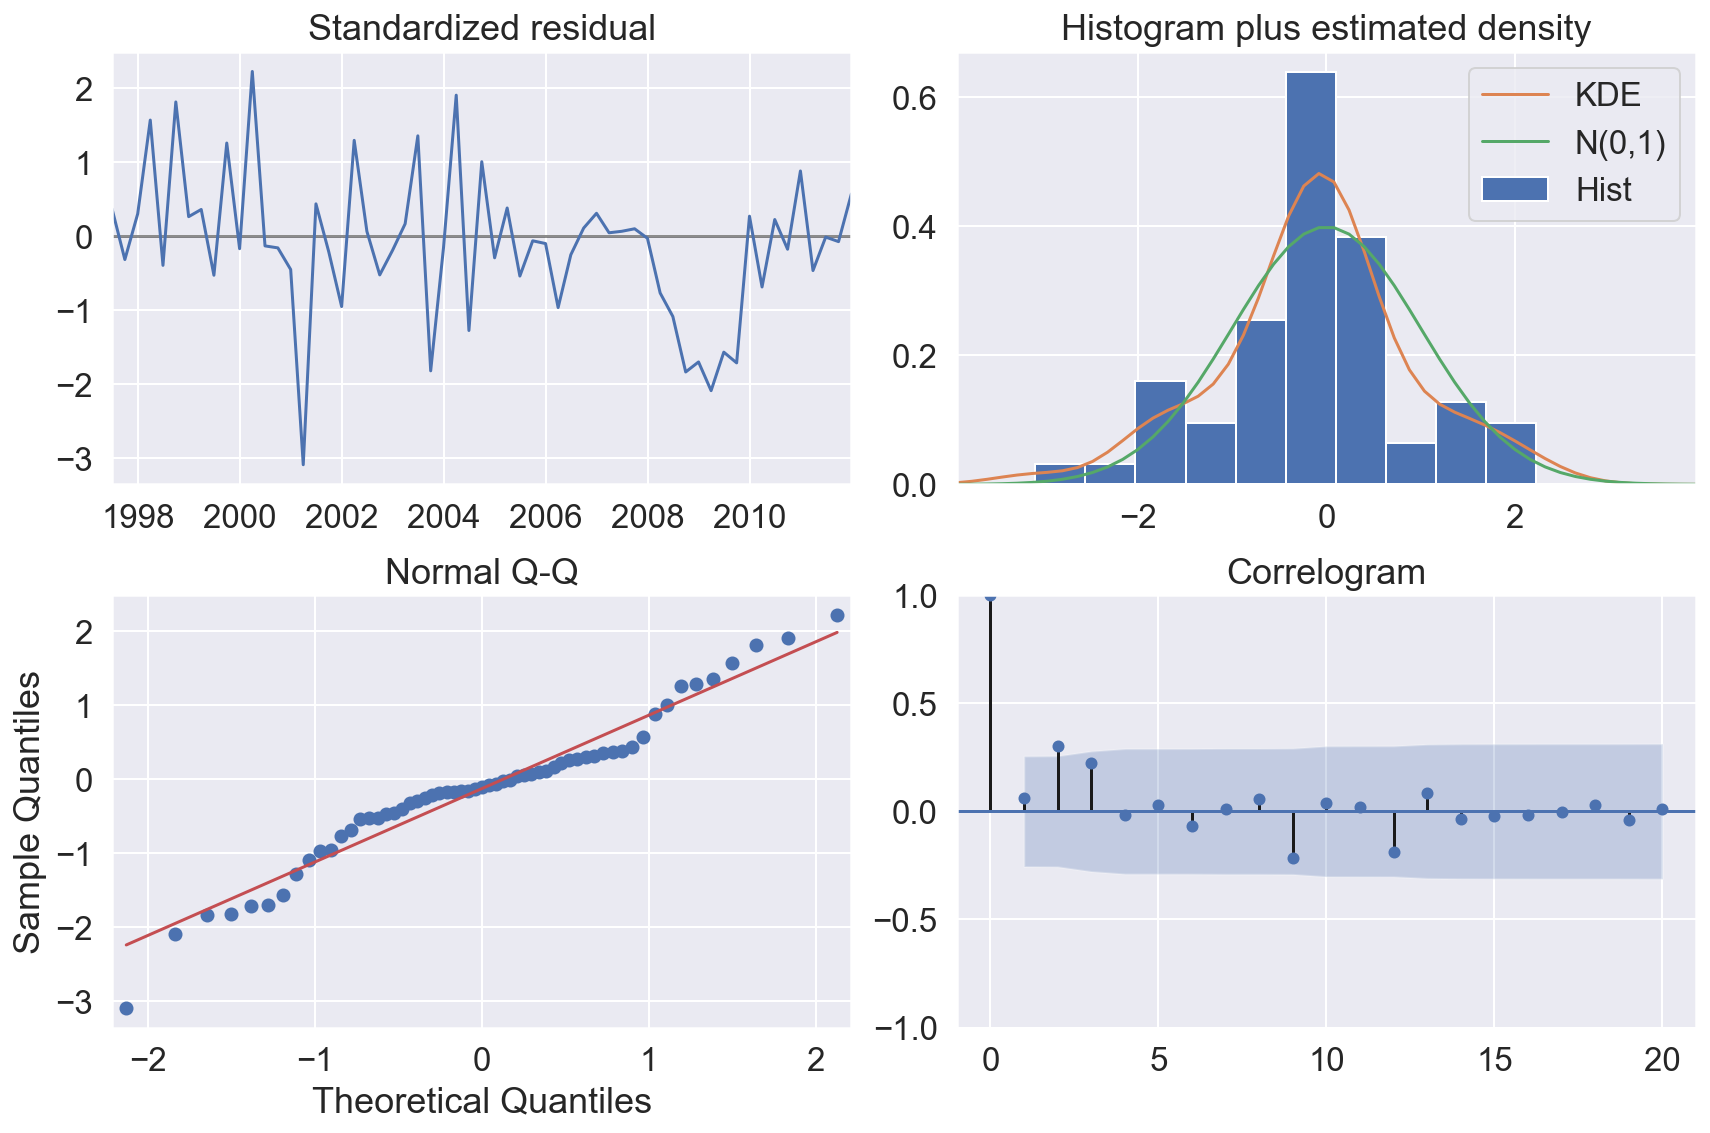

In [23]:
results.plot_diagnostics(figsize=(12, 8), lags=20)
plt.tight_layout()
plt.show()

## Increase the order of the SARIMAX model.

How do the results change?

In [24]:
model = sm.tsa.statespace.SARIMAX(
    data, order=(1, 1, 1), seasonal_order=(0, 1, 1, 4))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                              data   No. Observations:                   64
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 4)   Log Likelihood                 -30.187
Date:                           Sat, 17 Aug 2019   AIC                             68.374
Time:                                   15:06:52   BIC                             76.684
Sample:                               03-31-1996   HQIC                            71.618
                                    - 12-31-2011                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8823      0.176      5.022      0.000       0.538       1.227
ma.L1         -0.5204      0.218     -2.384      0.017      -0.948      -0.092
ma.S.L4       -0.9686      0.813     -1.191      0.234      -2.562       0.625
sigma2         0.1413      0.103      1.369      0.171      -0.061       0.344
===================================================================================
Ljung-Box (Q):                       22.92   Jarque-Bera (JB):                 1.49
Prob(Q):                              0.99   Prob(JB):                         0.47
Heteroskedasticity (H):               0.58   Skew:                             0.07
Prob(H) (two-sided):                  0.24   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
model = sm.tsa.statespace.SARIMAX(
    data, order=(0, 1, 2), seasonal_order=(0, 1, 1, 4))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                              data   No. Observations:                   64
Model:             SARIMAX(0, 1, 2)x(0, 1, 1, 4)   Log Likelihood                 -32.809
Date:                           Sat, 17 Aug 2019   AIC                             73.618
Time:                                   15:06:52   BIC                             81.928
Sample:                               03-31-1996   HQIC                            76.862
                                    - 12-31-2011                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2307      0.157      1.471      0.141      -0.077       0.538
ma.L2          0.2497      0.115      2.171      0.030       0.024       0.475
ma.S.L4       -0.6987      0.149     -4.695      0.000      -0.990      -0.407
sigma2         0.1694      0.028      5.944      0.000       0.114       0.225
===================================================================================
Ljung-Box (Q):                       33.80   Jarque-Bera (JB):                 1.55
Prob(Q):                              0.74   Prob(JB):                         0.46
Heteroskedasticity (H):               0.69   Skew:                            -0.10
Prob(H) (two-sided):                  0.41   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

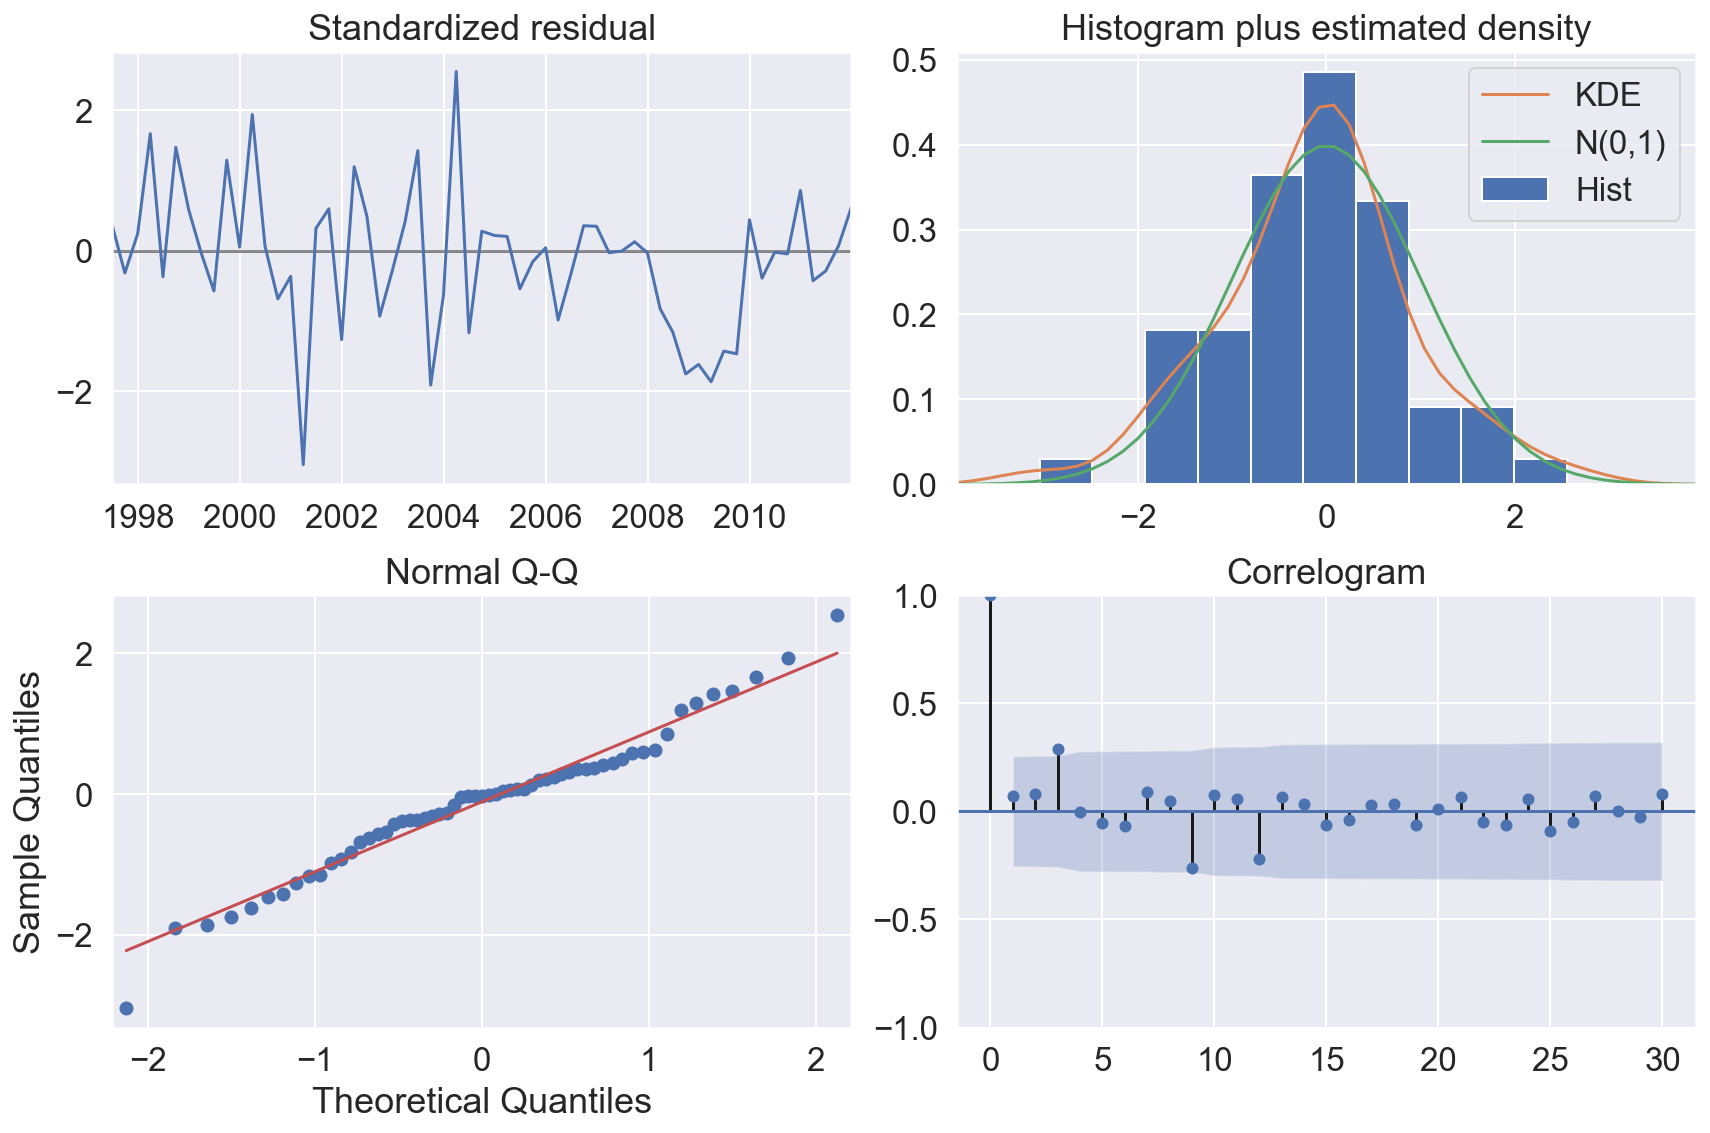

In [26]:
results.plot_diagnostics(figsize=(12, 8), lags=30)
plt.tight_layout()
plt.show()

AIC is slightly lower, so maybe a better choice.

## Forecast using the SARIMAX model
<a id="forecast-using-the-sarimax-model"></a>

Forecast 12 additional timepoints and plot them.

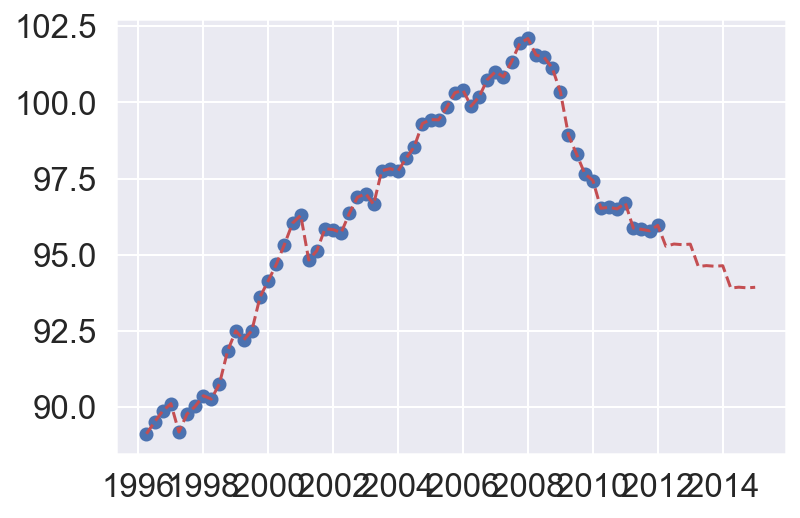

In [27]:
# forecasting
preds = results.forecast(12)
fcast = pd.concat([data, preds])

plt.figure()
plt.plot(data, 'o', fcast, 'r--')
plt.show()

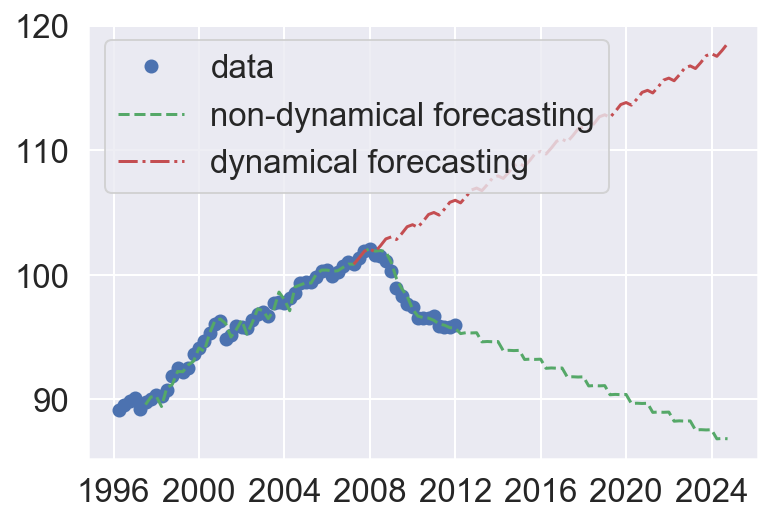

In [28]:
# forecasting
start_p = 20

preds = results.predict(start=0, end=len(data)+50, dynamic=False)

preds_dyn = results.predict(start=len(data)-start_p,
                            end=len(data)+50, dynamic=True)
fcast = pd.concat([data, preds])
fcast_1 = pd.concat([data[:len(data)-start_p], preds_dyn])


plt.figure()
plt.plot(data, 'bo', preds[5:], 'g--', preds_dyn, 'r-.')
plt.legend(['data', 'non-dynamical forecasting', 'dynamical forecasting'])
plt.show()

In [29]:
model = sm.tsa.statespace.SARIMAX(data, order=(
    (1), 1, (0, 1, 1)), seasonal_order=(0, 1, 1, 4))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     Statespace Model Results                                    
=================================================================================================
Dep. Variable:                                      data   No. Observations:                   64
Model:             SARIMAX(1, 1, (2, 3))x(0, 1, (4,), 4)   Log Likelihood                 -28.684
Date:                                   Sat, 17 Aug 2019   AIC                             67.369
Time:                                           15:06:54   BIC                             77.757
Sample:                                       03-31-1996   HQIC                            71.424
                                            - 12-31-2011                                         
Covariance Type:                                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2766      0.140      1.969      0.049       0.001       0.552
ma.L2          0.3141      0.140      2.248      0.025       0.040       0.588
ma.L3          0.3054      0.121      2.528      0.011       0.069       0.542
ma.S.L4       -0.7511      0.170     -4.427      0.000      -1.084      -0.419
sigma2         0.1442      0.029      4.984      0.000       0.088       0.201
===================================================================================
Ljung-Box (Q):                       17.27   Jarque-Bera (JB):                 0.88
Prob(Q):                              1.00   Prob(JB):                         0.64
Heteroskedasticity (H):               0.52   Skew:                             0.23
Prob(H) (two-sided):                  0.15   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""